In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import glob, pdb, os, sys, cv2
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
from angio import angio_abm, radial_persistence, level_set_flooding, Persist_im

In [2]:
#initialize simulation

#### chemoattractant distribution
# linear : profile linearly increases with x
# tumor  : profile max as the point (1,0.5) imitating a tumor center at that location
C_dist = 'linear'

#max time units a simulation can run
final_time = 20.0

#chemotaxis rate
chemo_rate = 'const'

#how many ABM sims to run simulation
ABM_sims = 10

#lists of chi & rho values to run the model for
chi_vec = [.15,.3,.45]
hapt_vec = [.15,.3,.45]#[0.1]#np.hstack((np.linspace(0,0.1,4),np.linspace(0.15,0.25,4),np.linspace(0.3,0.4,4)))

for hapt in hapt_vec:
    for chi in chi_vec:
        for i in np.arange(ABM_sims):
            
            #initialize ABM simulation
            A = angio_abm(C_dist,
                          rho = hapt,
                          t_final = final_time,
                          chi = chi,
                          chemo_rate = chemo_rate)

            #initialize chemoattractant and TAF grids, sprout locations
            A.IC_generate()
            A.sprout_initialize()

            #Record biological data (sprouts, tips, branches)
            A.record_bio_data()

            #Run the ABM until either one of the sprouts reaches x=0.95
            #or when time exceeds max_sim_time
            j = 0
            max_x = 0
            while max_x < 0.95:
                
                #move sprouts
                A.move_sprouts()
                #update TAF , chemoattractant
                A.update_grids()
                #perform branching
                A.branch()
                
                #Save bio info
                A.record_bio_data()

                #max x value reached by sprout tips
                max_x = np.max(A.X[A.N==1])

                j+=1
                if A.dt*j > final_time:
                    #stop simulation if time exceeds max_sim_time
                    break

            A.save_bio_data(i)

            #save left-to-right Topology data
            A.save_LR_TDA(i)
            #save persistance image data (via flooding)
            A.save_persim_TDA_flooding(i)

<IPython.core.display.Javascript object>


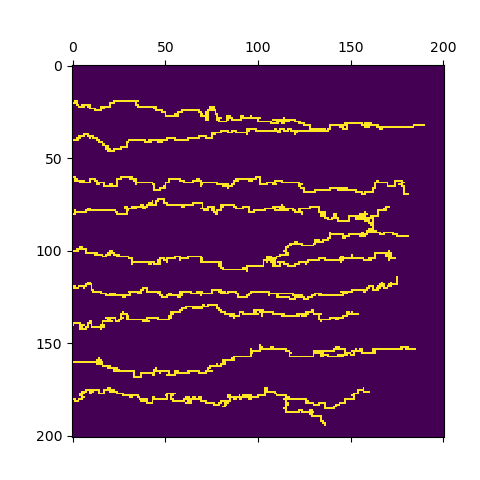

In [3]:
plt.matshow(A.N.T)